# Gene expression re-normalization

We need to renormalize gene expression to reduce chrM bias or MYC gene expression amplification bias.

# Outline
- [Introduction](#gene-expression-re-normalization)
- [Setup](#setup)
- [Data](#data)
- [Reproduce problem](#reproduce-chrm-bias)

# Setup

In [1]:
%load_ext autoreload
%autoreload 2
from taigapy import TaigaClient
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from cds import plotting
from mgenepy.utils import helper
#from depmap_omics_upload import tracker as track

tc = TaigaClient()

/home/ubuntu/mambaforge/envs/cds-omics/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Data

In [2]:
%%capture

OmicsExpressionProteinCodingGenesTPMLogp1 = tc.get(name='internal-23q4-ac2b', version=68, file='OmicsExpressionProteinCodingGenesTPMLogp1')

In [3]:
%%capture

OmicsExpressionAllGenesEffectiveLengthProfile = tc.get(name='internal-23q4-ac2b', version=68, file='OmicsExpressionAllGenesEffectiveLengthProfile')
OmicsExpressionAllGenesTPMLogp1Profile = tc.get(name='internal-23q4-ac2b', version=68, file='OmicsExpressionAllGenesTPMLogp1Profile')
OmicsExpressionGenesExpectedCountProfile = tc.get(name='internal-23q4-ac2b', version=68, file='OmicsExpressionGenesExpectedCountProfile')
OmicsDefaultModelProfiles = tc.get(name='internal-23q4-ac2b', version=68, file='OmicsDefaultModelProfiles')
OmicsDefaultModelConditionProfiles = tc.get(name='internal-23q4-ac2b', version=68, file='OmicsDefaultModelConditionProfiles')


In [4]:
profile_to_model_dict = OmicsDefaultModelProfiles.query("ProfileType == 'rna'").\
        set_index("ProfileID").\
        drop("ProfileType", axis=1).\
        to_dict()["ModelID"]

In [5]:
# mytracker = track.SampleTracker()
# pr_table = mytracker.read_pr_table()

In [6]:
OmicsExpressionProteinCodingGenesTPMLogp1.shape, \
    OmicsExpressionAllGenesEffectiveLengthProfile.shape, \
    OmicsExpressionAllGenesTPMLogp1Profile.shape, \
    OmicsExpressionGenesExpectedCountProfile.shape, \
    OmicsExpressionProteinCodingGenesTPMLogp1.shape

((1882, 19193), (1904, 60605), (1904, 53961), (1904, 54353), (1882, 19193))

In [7]:
OmicsExpressionAllGenesEffectiveLengthProfile_matched_genes = OmicsExpressionAllGenesEffectiveLengthProfile.loc[:, OmicsExpressionGenesExpectedCountProfile.columns]

In [8]:
OmicsExpressionAllGenesEffectiveLengthProfile_matched_genes.shape, OmicsExpressionGenesExpectedCountProfile.shape

((1904, 54353), (1904, 54353))

# Reproduce TPM for protein coding genes

In [9]:
def calculate_tpm(counts_df, transcripts_length_df):
    """https://github.com/deweylab/RSEM/blob/8bc1e2115493c0cdf3c6bee80ef7a21a91b2acce/WriteResults.h#L77"""
    assert counts_df.shape == transcripts_length_df.shape

    denom = counts_df.sum(axis=1)
    denom = denom.where(denom > 1e-300, 1)
    print(denom.isnull().sum().sum())
    frac = counts_df.div(denom, axis=0)
    print(frac.isnull().sum().sum())

    transcripts_length_df = transcripts_length_df.where(transcripts_length_df > 1e-300, 1)
    fpkm = frac * 1e9 / transcripts_length_df
    print(fpkm.isnull().sum().sum())

    fpkm_sum = fpkm.sum(axis=1)
    fpkm_denom = fpkm_sum.where(fpkm_sum > 1e-300, 1)
    print(fpkm_denom.isnull().sum().sum())

    tpm_df = (fpkm.div(fpkm_denom, axis=0)) * 1e6
    print(tpm_df.isnull().sum().sum())
    return np.log2(tpm_df+1)

In [10]:
OmicsExpressionGenesExpectedCountProfile_tpm = calculate_tpm(OmicsExpressionGenesExpectedCountProfile, OmicsExpressionAllGenesEffectiveLengthProfile_matched_genes)

0
0
0
0
0


In [11]:
mybiomart = helper.generateGeneNames(ensemble_server="http://nov2020.archive.ensembl.org/biomart", useCache=False)

downloading gene names from biomart


In [12]:
protcod_rename = {}
for _, i in mybiomart[
    (~mybiomart.entrezgene_id.isna()) & (mybiomart.gene_biotype == "protein_coding")
].iterrows():
    if i.ensembl_gene_id not in protcod_rename:
        protcod_rename.update(
            {
                i.hgnc_symbol + " (" + i.ensembl_gene_id + ")": i.hgnc_symbol
                + " ("
                + str(int(i.entrezgene_id))
                + ")"
            }
        )

In [13]:
OmicsExpressionGenesExpectedCountProfile_tpm.columns = OmicsExpressionGenesExpectedCountProfile_tpm.columns.map(protcod_rename)
OmicsExpressionGenesExpectedCountProfile_tpm = OmicsExpressionGenesExpectedCountProfile_tpm.loc[:, ~OmicsExpressionGenesExpectedCountProfile_tpm.columns.isnull()]

In [14]:
OmicsExpressionAllGenesTPMLogp1Profile.columns = OmicsExpressionAllGenesTPMLogp1Profile.columns.map(protcod_rename)
OmicsExpressionAllGenesTPMLogp1Profile = OmicsExpressionAllGenesTPMLogp1Profile.loc[:, ~OmicsExpressionAllGenesTPMLogp1Profile.columns.isnull()]

In [15]:
from scipy.stats import pearsonr

tpm_correlation_list = []
for gene in OmicsExpressionAllGenesTPMLogp1Profile.columns:
    tpm_correlation_list.append(pearsonr(OmicsExpressionGenesExpectedCountProfile_tpm.loc[:, gene], OmicsExpressionAllGenesTPMLogp1Profile.loc[:, gene])[0])

In [16]:
np.isnan(tpm_correlation_list).sum(), np.min(tpm_correlation_list)

(0, 0.856137599505253)

<Axes: ylabel='Density'>

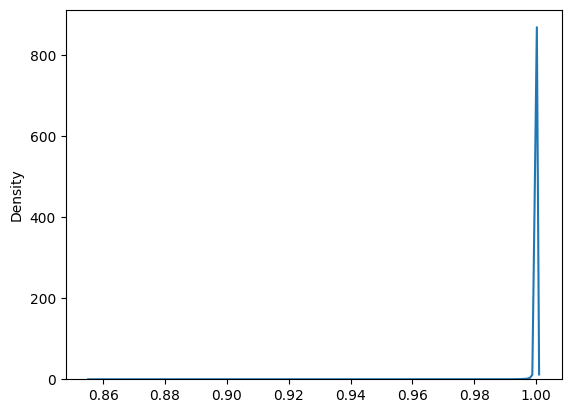

In [17]:
sns.kdeplot(tpm_correlation_list)

In [18]:
OmicsExpressionGenesExpectedCountProfile_tpm.isnull().sum().sum()

0

In [19]:
OmicsExpressionGenesExpectedCountProfile_tpm.loc[:, "Model"] = OmicsExpressionGenesExpectedCountProfile_tpm.index.map(profile_to_model_dict)
OmicsExpressionGenesExpectedCountModel_tpm = OmicsExpressionGenesExpectedCountProfile_tpm.set_index("Model")
OmicsExpressionGenesExpectedCountModel_tpm = OmicsExpressionGenesExpectedCountModel_tpm.loc[OmicsExpressionProteinCodingGenesTPMLogp1.index, :]

In [20]:
OmicsExpressionGenesExpectedCountProfile_tpm.shape

(1904, 19194)

# Reproduce chrM bias

In [21]:
sample_median_expression = OmicsExpressionProteinCodingGenesTPMLogp1.median(axis=1)
sample_median_expression_rank = sample_median_expression.rank()

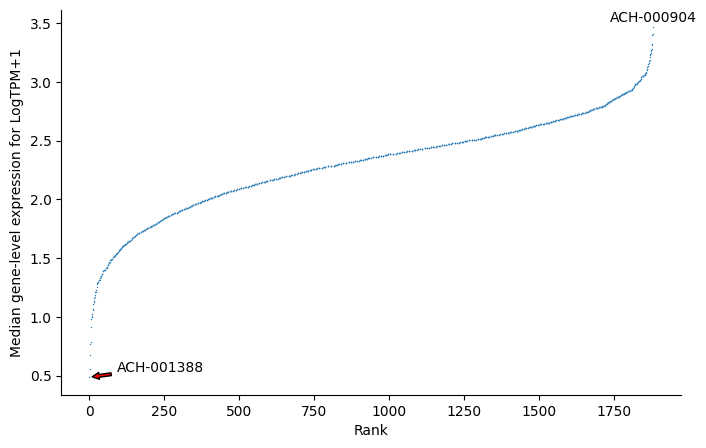

In [22]:
top_1_sample_index = sample_median_expression.argmax()
top_1_sample_rank = sample_median_expression_rank[top_1_sample_index]
top_1_sample = sample_median_expression.index[top_1_sample_index]
top_1_sample_expression = sample_median_expression[top_1_sample_index]
bottom_1_sample_index = sample_median_expression.argmin()
bottom_1_sample_rank = sample_median_expression_rank[bottom_1_sample_index]
bottom_1_sample = sample_median_expression.index[bottom_1_sample_index]
bottom_1_sample_expression = sample_median_expression[bottom_1_sample_index]

fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
sns.scatterplot(y=sample_median_expression, x=sample_median_expression_rank, ax=ax, s=1)
ax.set_xlabel("Rank")
ax.set_ylabel("Median gene-level expression for LogTPM+1")
ax.annotate(top_1_sample, xy=(top_1_sample_rank, top_1_sample_expression), xytext=(0, 2), ha='center', textcoords='offset points', va='bottom')
ax.annotate(bottom_1_sample, xy=(bottom_1_sample_rank, bottom_1_sample_expression), 
            xytext=(bottom_1_sample_rank+50, 2), ha='center', va='bottom', textcoords='offset points', 
                arrowprops = dict(arrowstyle="simple", facecolor='red'))

sns.despine()

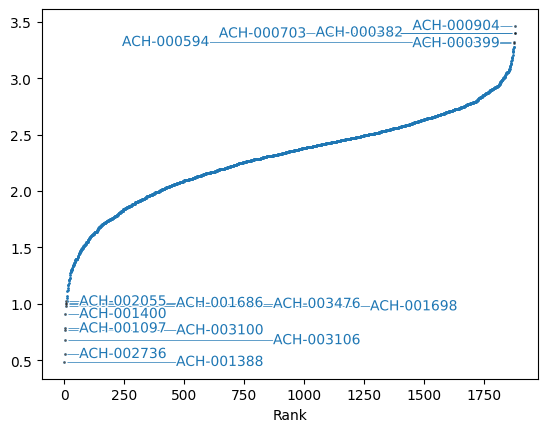

In [23]:
plotting.waterfall_plot(sample_median_expression, s=1)

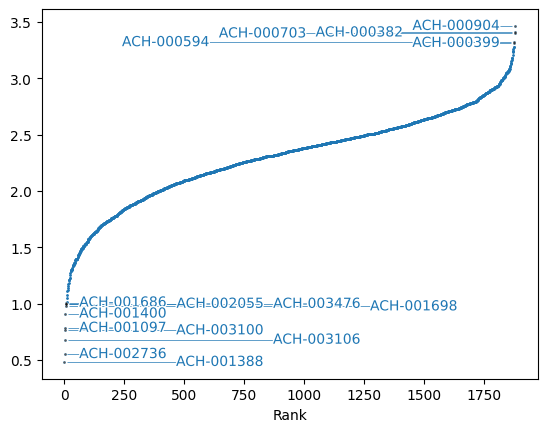

In [24]:
new_sample_median_expression = OmicsExpressionGenesExpectedCountModel_tpm.median(axis=1)
plotting.waterfall_plot(new_sample_median_expression, s=1)

In [25]:
new_sample_median_expression.head()

ACH-001113    2.577495
ACH-001289    2.433611
ACH-001339    2.251976
ACH-001979    1.856811
ACH-002438    2.345780
dtype: float64

/home/ubuntu/mambaforge/envs/cds-omics/lib/python3.9/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/home/ubuntu/mambaforge/envs/cds-omics/lib/python3.9/site-packages/cds/plotting/__init__.py:537: UserWarning: adjustText not found. Install to have labels moved off points.
  warn("adjustText not found. Install to have labels moved off points.")


(0.0, 18.0)

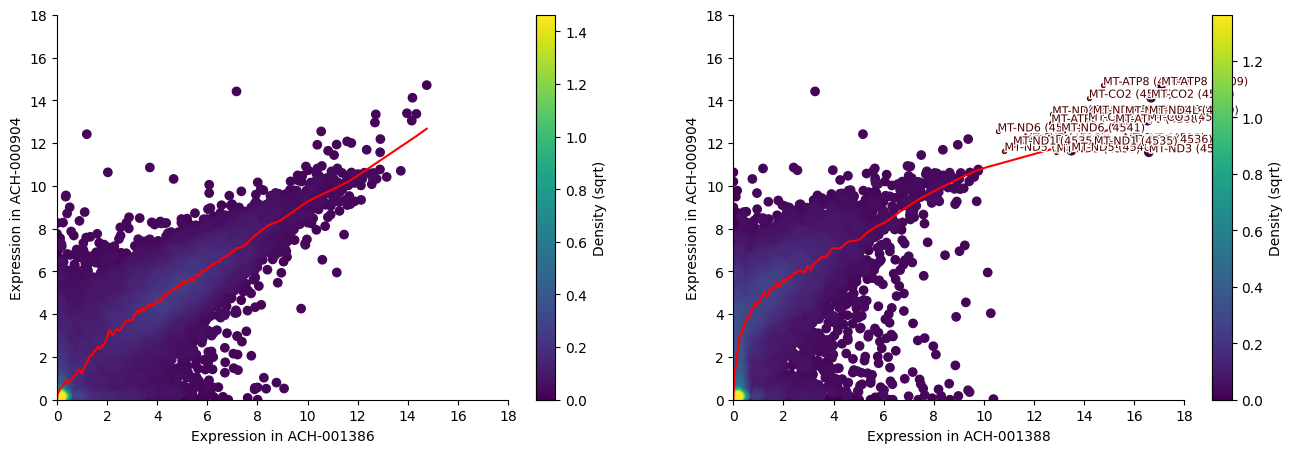

In [26]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(16, 5)
chrM_labels = OmicsExpressionProteinCodingGenesTPMLogp1.columns[OmicsExpressionProteinCodingGenesTPMLogp1.columns.str.contains("^MT-")]
highest_sample = OmicsExpressionProteinCodingGenesTPMLogp1.loc['ACH-001386', :]
lowest_sample = OmicsExpressionProteinCodingGenesTPMLogp1.loc['ACH-000904', :]
plotting.density_scatter(highest_sample,
                         lowest_sample, ax=ax[0],
                         label_specific=chrM_labels)
sns.despine()
                         
ax[0].set_xlabel("Expression in ACH-001386")
ax[0].set_ylabel("Expression in ACH-000904")
ax[0].set_xlim(0, 18)
ax[0].set_ylim(0, 18)

highest_sample = OmicsExpressionProteinCodingGenesTPMLogp1.loc['ACH-001388', :]
lowest_sample = OmicsExpressionProteinCodingGenesTPMLogp1.loc['ACH-000904', :]
plotting.density_scatter(highest_sample,
                         lowest_sample, ax=ax[1],
                         label_specific=chrM_labels)
sns.despine()
                         
ax[1].set_xlabel("Expression in ACH-001388")
ax[1].set_ylabel("Expression in ACH-000904")
ax[1].set_xlim(0, 18)
ax[1].set_ylim(0, 18)

(0.0, 18.0)

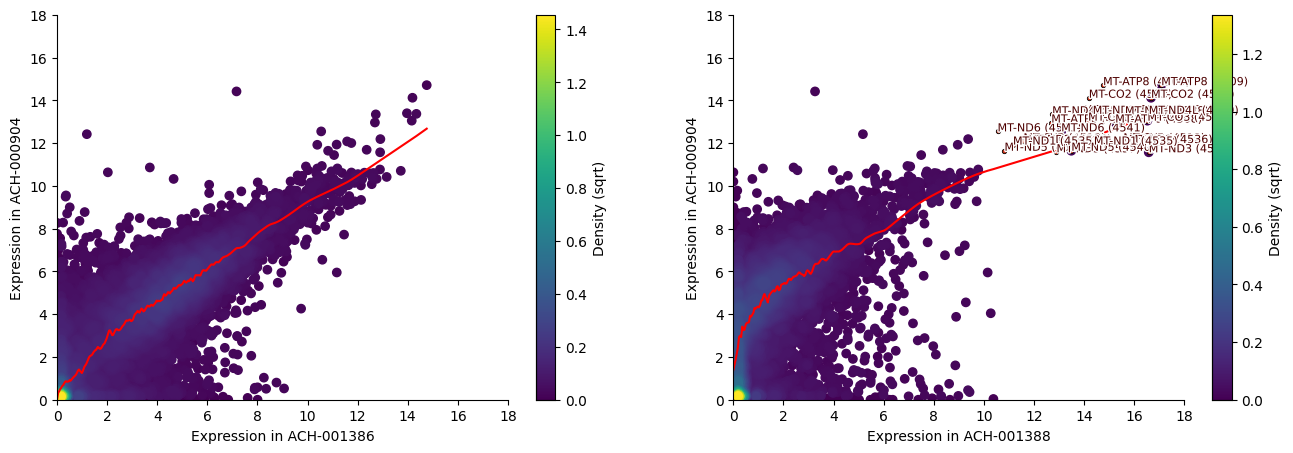

In [27]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(16, 5)
chrM_labels = OmicsExpressionGenesExpectedCountModel_tpm.columns[OmicsExpressionGenesExpectedCountModel_tpm.columns.str.contains("^MT-")]
highest_sample = OmicsExpressionGenesExpectedCountModel_tpm.loc['ACH-001386', :]
lowest_sample = OmicsExpressionGenesExpectedCountModel_tpm.loc['ACH-000904', :]
plotting.density_scatter(highest_sample,
                         lowest_sample, ax=ax[0],
                         label_specific=chrM_labels)
sns.despine()
                         
ax[0].set_xlabel("Expression in ACH-001386")
ax[0].set_ylabel("Expression in ACH-000904")
ax[0].set_xlim(0, 18)
ax[0].set_ylim(0, 18)

highest_sample = OmicsExpressionGenesExpectedCountModel_tpm.loc['ACH-001388', :]
lowest_sample = OmicsExpressionGenesExpectedCountModel_tpm.loc['ACH-000904', :]
plotting.density_scatter(highest_sample,
                         lowest_sample, ax=ax[1],
                         label_specific=chrM_labels)
sns.despine()
                         
ax[1].set_xlabel("Expression in ACH-001388")
ax[1].set_ylabel("Expression in ACH-000904")
ax[1].set_xlim(0, 18)
ax[1].set_ylim(0, 18)

Text(0.5, 0, 'All gene median expression')

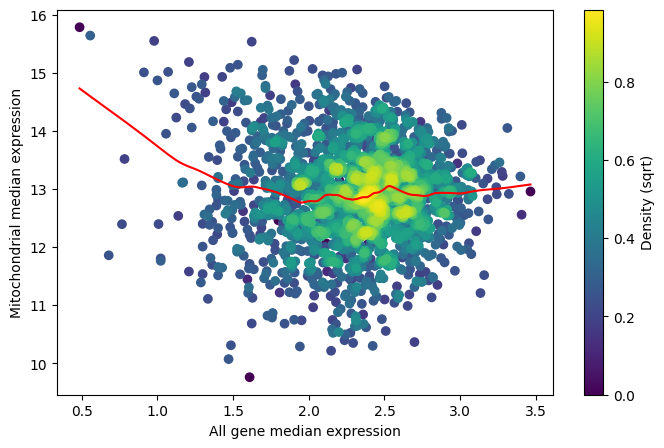

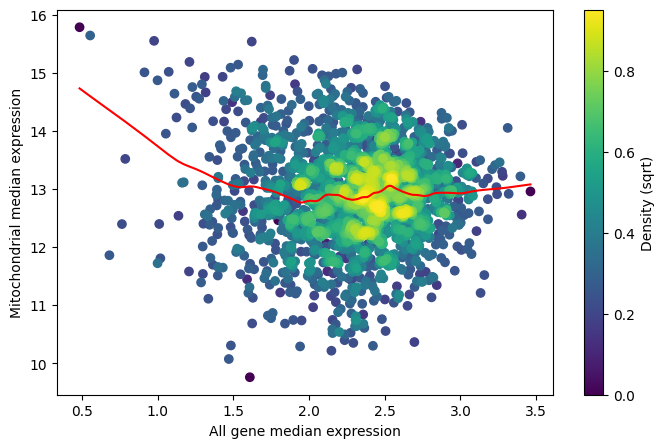

In [28]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
plotting.density_scatter(OmicsExpressionProteinCodingGenesTPMLogp1.loc[:, :].median(axis=1),
                         OmicsExpressionProteinCodingGenesTPMLogp1.loc[:, chrM_labels].median(axis=1),
                         ax=ax)
ax.set_ylabel("Mitochondrial median expression")
ax.set_xlabel("All gene median expression")

fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
plotting.density_scatter(OmicsExpressionGenesExpectedCountModel_tpm.loc[:, :].median(axis=1),
                         OmicsExpressionGenesExpectedCountModel_tpm.loc[:, chrM_labels].median(axis=1),
                         ax=ax)
ax.set_ylabel("Mitochondrial median expression")
ax.set_xlabel("All gene median expression")

# Apply the correction

In [38]:
def calculate_tpm_correct_chrM(counts_df, transcripts_length_df):
    """https://github.com/deweylab/RSEM/blob/8bc1e2115493c0cdf3c6bee80ef7a21a91b2acce/WriteResults.h#L77"""
    assert counts_df.shape == transcripts_length_df.shape
    EPSILON = 1e-300

    chrM_labels = counts_df.columns.str.contains("^MT-")
    print(chrM_labels.sum())

    denom = counts_df.loc[:, ~chrM_labels].sum(axis=1)
    denom = denom.where(denom > EPSILON, 1)
    print(denom.isnull().sum().sum())
    frac = counts_df.div(denom, axis=0)
    print(frac.isnull().sum().sum())

    transcripts_length_df = transcripts_length_df.where(transcripts_length_df > EPSILON, 1)
    fpkm = frac * 1e9 / transcripts_length_df
    print(fpkm.isnull().sum().sum())

    fpkm_sum = fpkm.loc[:, ~chrM_labels].sum(axis=1)
    fpkm_denom = fpkm_sum.where(fpkm_sum > EPSILON, 1)
    print(fpkm_denom.isnull().sum().sum())

    tpm_df = (fpkm.div(fpkm_denom, axis=0)) * 1e6
    print(tpm_df.isnull().sum().sum())
    return np.log2(tpm_df+1)

In [39]:
OmicsExpressionGenesExpectedCountProfile_tpm_chrM = calculate_tpm_correct_chrM(OmicsExpressionGenesExpectedCountProfile, 
                                                                               OmicsExpressionAllGenesEffectiveLengthProfile_matched_genes)
OmicsExpressionGenesExpectedCountProfile_tpm_chrM.columns = OmicsExpressionGenesExpectedCountProfile_tpm_chrM.columns.map(protcod_rename)
OmicsExpressionGenesExpectedCountProfile_tpm_chrM = OmicsExpressionGenesExpectedCountProfile_tpm_chrM.loc[:, ~OmicsExpressionGenesExpectedCountProfile_tpm_chrM.columns.isnull()]

OmicsExpressionGenesExpectedCountProfile_tpm_chrM.loc[:, "Model"] = OmicsExpressionGenesExpectedCountProfile_tpm_chrM.index.map(profile_to_model_dict)
OmicsExpressionGenesExpectedCountModel_tpm_chrM = OmicsExpressionGenesExpectedCountProfile_tpm_chrM.set_index("Model")
OmicsExpressionGenesExpectedCountModel_tpm_chrM = OmicsExpressionGenesExpectedCountModel_tpm_chrM.loc[OmicsExpressionProteinCodingGenesTPMLogp1.index, :]

15
0
0
0
0
0


Text(0.5, 0, 'All gene median expression')

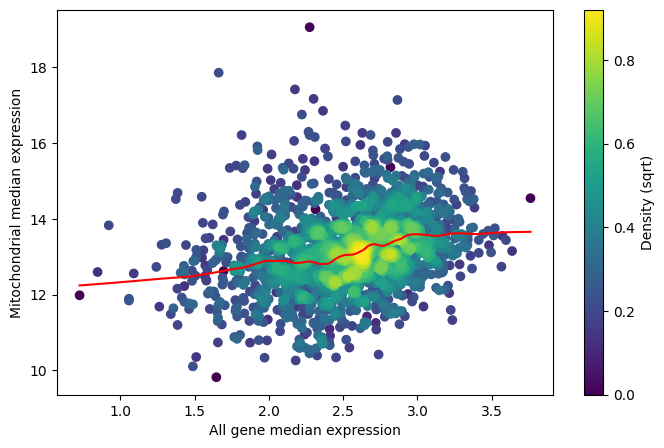

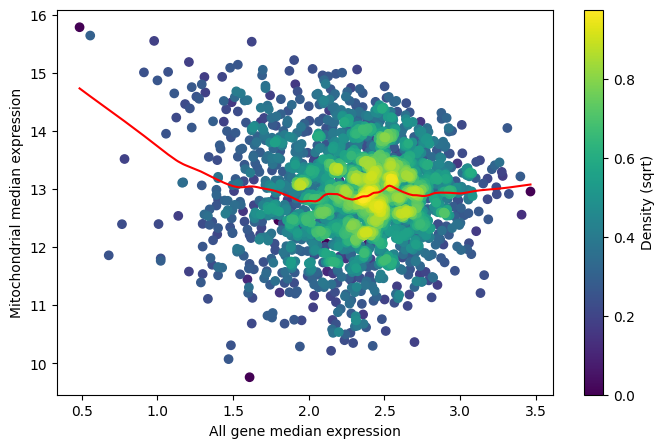

In [40]:
chrM_labels = OmicsExpressionGenesExpectedCountModel_tpm.columns[OmicsExpressionGenesExpectedCountModel_tpm.columns.str.contains("^MT-")]

fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
plotting.density_scatter(OmicsExpressionGenesExpectedCountModel_tpm_chrM.loc[:, :].median(axis=1),
                         OmicsExpressionGenesExpectedCountModel_tpm_chrM.loc[:, chrM_labels].median(axis=1),
                         ax=ax)
ax.set_ylabel("Mitochondrial median expression")
ax.set_xlabel("All gene median expression")

fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
plotting.density_scatter(OmicsExpressionAllGenesTPMLogp1Profile.loc[:, :].median(axis=1),
                         OmicsExpressionAllGenesTPMLogp1Profile.loc[:, chrM_labels].median(axis=1),
                         ax=ax)
ax.set_ylabel("Mitochondrial median expression")
ax.set_xlabel("All gene median expression")

/home/ubuntu/mambaforge/envs/cds-omics/lib/python3.9/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/home/ubuntu/mambaforge/envs/cds-omics/lib/python3.9/site-packages/cds/plotting/__init__.py:537: UserWarning: adjustText not found. Install to have labels moved off points.
  warn("adjustText not found. Install to have labels moved off points.")


Text(0, 0.5, 'Expression in ACH-000904')

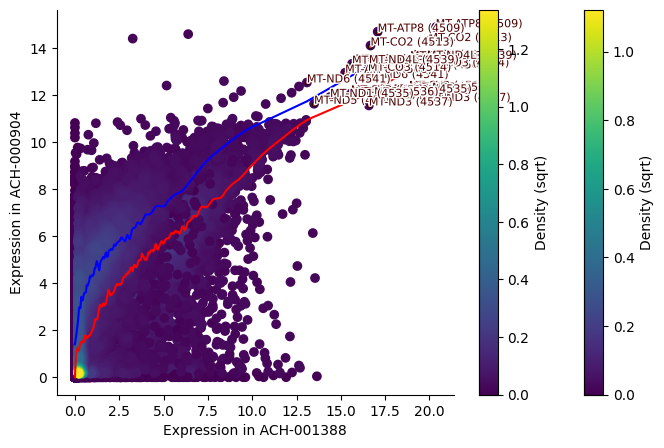

In [41]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)

highest_sample = OmicsExpressionGenesExpectedCountModel_tpm_chrM.loc['ACH-001388', :]
lowest_sample = OmicsExpressionGenesExpectedCountModel_tpm_chrM.loc['ACH-000904', :]
plotting.density_scatter(highest_sample,
                         lowest_sample, ax=ax,
                         label_specific=chrM_labels)
sns.despine()
                         
ax.set_xlabel("Expression in ACH-001388")
ax.set_ylabel("Expression in ACH-000904")
#ax[0].set_xlim(0, 18)
#ax[0].set_ylim(0, 18)

# fig, ax = plt.subplots()
# fig.set_size_inches(8, 5)
highest_sample = OmicsExpressionGenesExpectedCountModel_tpm.loc['ACH-001388', :]
lowest_sample = OmicsExpressionGenesExpectedCountModel_tpm.loc['ACH-000904', :]
plotting.density_scatter(highest_sample,
                         lowest_sample, ax=ax,
                         trend_line_args={'color': 'b'},
                         label_specific=chrM_labels)
sns.despine()
                       
ax.set_xlabel("Expression in ACH-001388")
ax.set_ylabel("Expression in ACH-000904")
#ax[1].set_xlim(0, 18)
#ax[1].set_ylim(0, 18)

Text(0, 0.5, 'Expression in ACH-000904')

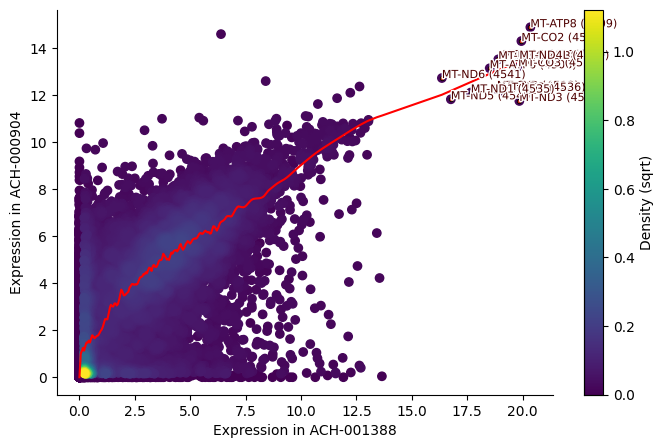

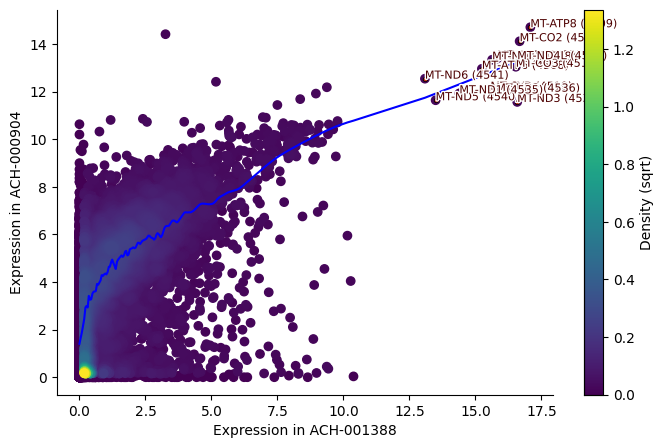

In [42]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)

highest_sample = OmicsExpressionGenesExpectedCountModel_tpm_chrM.loc['ACH-001388', :]
lowest_sample = OmicsExpressionGenesExpectedCountModel_tpm_chrM.loc['ACH-000904', :]
plotting.density_scatter(highest_sample,
                         lowest_sample, ax=ax,
                         label_specific=chrM_labels)
sns.despine()
                         
ax.set_xlabel("Expression in ACH-001388")
ax.set_ylabel("Expression in ACH-000904")
#ax[0].set_xlim(0, 18)
#ax[0].set_ylim(0, 18)

fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
highest_sample = OmicsExpressionGenesExpectedCountModel_tpm.loc['ACH-001388', :]
lowest_sample = OmicsExpressionGenesExpectedCountModel_tpm.loc['ACH-000904', :]
plotting.density_scatter(highest_sample,
                         lowest_sample, ax=ax,
                         trend_line_args={'color': 'b'},
                         label_specific=chrM_labels)
sns.despine()
                       
ax.set_xlabel("Expression in ACH-001388")
ax.set_ylabel("Expression in ACH-000904")
#ax[1].set_xlim(0, 18)
#ax[1].set_ylim(0, 18)

## Upload this new version of datasets

In [43]:
OmicsExpressionGenesExpectedCountModel_tpm_chrM.to_csv("OmicsExpressionGenesExpectedCountModel_tpm_chrM.csv")

In [45]:
update = False
if update:
    new_dataset_id = tc.update_dataset(
        "post-23q4-gene-expression-renormalization-chrM",
        changes_description="post 23Q4 adjust gene expression normalization",
        upload_files=[
            {
                "path": "OmicsExpressionGenesExpectedCountModel_tpm_chrM",
                "name": "OmicsExpressionGenesExpectedCountModel_tpm_chrM", # optional, will use file name if not provided
                "format": "NumericMatrixCSV", # or "NumericMatrixCSV" or "TableCSV"
                "encoding": "utf-8" # optional (but recommended), will use iso-8859-1 if not provided
            }
        ],
        add_all_existing_files=True,
    )
else:
    new_dataset_id = tc.create_dataset(
        "post-23q4-gene-expression-renormalization-chrM",
        dataset_description="post 23Q4 adjust gene expression normalization",
        upload_files=[
            {
                "path": "OmicsExpressionGenesExpectedCountModel_tpm_chrM.csv",
                "name": "OmicsExpressionGenesExpectedCountModel_tpm_chrM", # optional, will use file name if not provided
                "format": "NumericMatrixCSV", # or "NumericMatrixCSV" or "TableCSV"
                "encoding": "utf-8" # optional (but recommended), will use iso-8859-1 if not provided
            }
        ],
        folder_id="a9eedc220a6a4e70b8f1e64d2e57ed87", # optional, will default to your home folder if not provided
    )

new_dataset_id

Uploading OmicsExpressionGenesExpectedCountModel_tpm_chrM to S3
Finished uploading OmicsExpressionGenesExpectedCountModel_tpm_chrM to S3
Uploading OmicsExpressionGenesExpectedCountModel_tpm_chrM to Taiga
Finished uploading OmicsExpressionGenesExpectedCountModel_tpm_chrM to Taiga
Dataset created. Access it directly with this url: https://cds.team/taiga/dataset/3a249cff05b042f79e56a54daeb6f6c4



'3a249cff05b042f79e56a54daeb6f6c4'

# Square root normalization

In [34]:
def calculate_tpm_correct_chrM(counts_df, transcripts_length_df):
    """https://github.com/deweylab/RSEM/blob/8bc1e2115493c0cdf3c6bee80ef7a21a91b2acce/WriteResults.h#L77"""
    assert counts_df.shape == transcripts_length_df.shape
    EPSILON = 1e-300

    chrM_labels = counts_df.columns.str.contains("^MT-")
    print(chrM_labels.sum())

    denom = counts_df.loc[:, ~chrM_labels].sum(axis=1)
    denom = denom.where(denom > EPSILON, 1)
    print(denom.isnull().sum().sum())
    frac = counts_df.div(denom, axis=0)
    print(frac.isnull().sum().sum())

    transcripts_length_df = transcripts_length_df.where(transcripts_length_df > EPSILON, 1)
    fpkm = frac * 1e9 / transcripts_length_df
    print(fpkm.isnull().sum().sum())

    fpkm_sum = fpkm.loc[:, ~chrM_labels].sum(axis=1)
    fpkm_denom = fpkm_sum.where(fpkm_sum > EPSILON, 1)
    print(fpkm_denom.isnull().sum().sum())

    tpm_df = (fpkm.div(fpkm_denom, axis=0)) * 1e6
    print(tpm_df.isnull().sum().sum())
    return np.sqrt(tpm_df+1)

In [35]:
OmicsExpressionGenesExpectedCountProfile_tpm_chrM = calculate_tpm_correct_chrM(OmicsExpressionGenesExpectedCountProfile, 
                                                                               OmicsExpressionAllGenesEffectiveLengthProfile_matched_genes)
OmicsExpressionGenesExpectedCountProfile_tpm_chrM.columns = OmicsExpressionGenesExpectedCountProfile_tpm_chrM.columns.map(protcod_rename)
OmicsExpressionGenesExpectedCountProfile_tpm_chrM = OmicsExpressionGenesExpectedCountProfile_tpm_chrM.loc[:, ~OmicsExpressionGenesExpectedCountProfile_tpm_chrM.columns.isnull()]

OmicsExpressionGenesExpectedCountProfile_tpm_chrM.loc[:, "Model"] = OmicsExpressionGenesExpectedCountProfile_tpm_chrM.index.map(profile_to_model_dict)
OmicsExpressionGenesExpectedCountModel_tpm_chrM = OmicsExpressionGenesExpectedCountProfile_tpm_chrM.set_index("Model")
OmicsExpressionGenesExpectedCountModel_tpm_chrM = OmicsExpressionGenesExpectedCountModel_tpm_chrM.loc[OmicsExpressionProteinCodingGenesTPMLogp1.index, :]

15
0
0
0
0
0


Text(0.5, 0, 'All gene median expression')

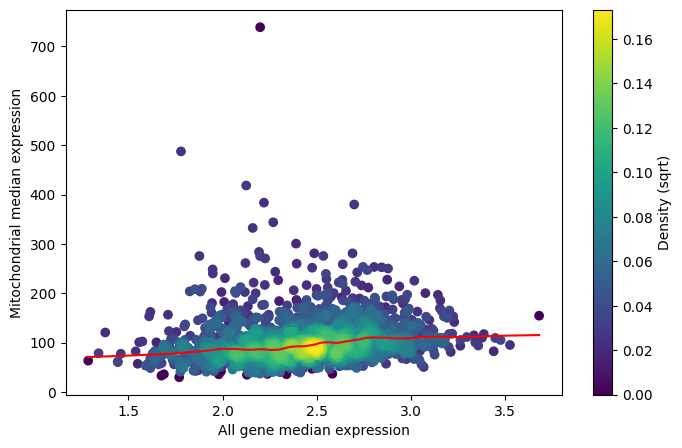

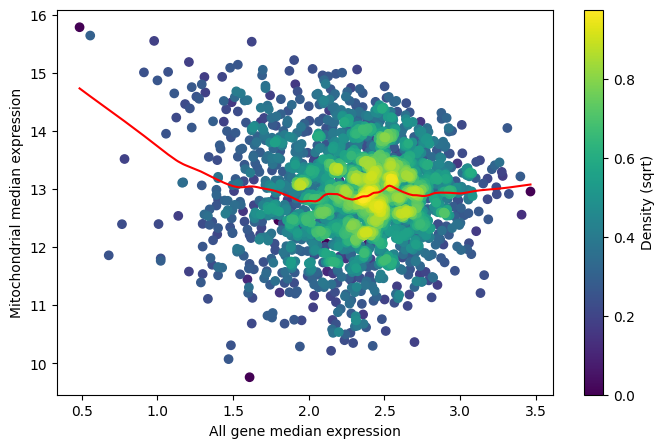

In [36]:
chrM_labels = OmicsExpressionGenesExpectedCountModel_tpm_chrM.columns[OmicsExpressionGenesExpectedCountModel_tpm_chrM.columns.str.contains("^MT-")]

fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
plotting.density_scatter(OmicsExpressionGenesExpectedCountModel_tpm_chrM.loc[:, :].median(axis=1),
                         OmicsExpressionGenesExpectedCountModel_tpm_chrM.loc[:, chrM_labels].median(axis=1),
                         ax=ax)
ax.set_ylabel("Mitochondrial median expression")
ax.set_xlabel("All gene median expression")

fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
plotting.density_scatter(OmicsExpressionAllGenesTPMLogp1Profile.loc[:, :].median(axis=1),
                         OmicsExpressionAllGenesTPMLogp1Profile.loc[:, chrM_labels].median(axis=1),
                         ax=ax)
ax.set_ylabel("Mitochondrial median expression")
ax.set_xlabel("All gene median expression")

In [37]:
%pwd

'/home/ubuntu/depmap_omics/ccle_tasks'